# SVM model

## Importing necessary libraries


In [11]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d budincsevity/szeged-weather

  0% 0.00/2.23M [00:00<?, ?B/s]
100% 2.23M/2.23M [00:00<00:00, 105MB/s]


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import zipfile
import time
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


##Data Cleaning

In [13]:
with zipfile.ZipFile("szeged-weather.zip", "r") as zip_ref:
    zip_ref.extractall("data")

dt = pd.read_csv("data/weatherHistory.csv")

In [14]:
dt.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [15]:
dt.rename(columns = {col:col.replace(' ','_') for col in dt.columns},inplace = True)
print(dt.columns)

Index(['Formatted_Date', 'Summary', 'Precip_Type', 'Temperature_(C)',
       'Apparent_Temperature_(C)', 'Humidity', 'Wind_Speed_(km/h)',
       'Wind_Bearing_(degrees)', 'Visibility_(km)', 'Loud_Cover',
       'Pressure_(millibars)', 'Daily_Summary'],
      dtype='object')


In [16]:
dt.describe()

,Temperature_(C),Apparent_Temperature_(C),Humidity,Wind_Speed_(km/h),Wind_Bearing_(degrees),Visibility_(km),Loud_Cover,Pressure_(millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [17]:
dt.describe(include = 'O')

,Formatted_Date,Summary,Precip_Type,Daily_Summary
count,96453,96453,95936,96453
unique,96429,27,2,214
top,2010-08-02 00:00:00.000 +0200,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,2,31733,85224,20085


In [18]:
# Rename columns with underscores
dt.columns = [col.replace(' ', '_') for col in dt.columns]

In [19]:
# Drop redundant column 'Loud_Cover'
dt.drop('Loud_Cover', axis=1, inplace=True)

In [20]:
# Convert the Formatted_Date Columns datatype to Datetime.
dt['Formatted_Date']=pd.to_datetime(dt['Formatted_Date'],format='%Y-%m-%d %H:%M:%S.%f',utc=True)

# Seperate tht Formatted_Date columns to Year, Month, Day, and Hours Column
dt['Year'] = dt['Formatted_Date'].dt.year
dt['Month'] = dt['Formatted_Date'].dt.month
dt['Day'] = dt['Formatted_Date'].dt.dayofyear
dt['Hour'] = dt['Formatted_Date'].dt.hour

#Drop the Formatted_Date Columns
column_name = 'Formatted_Date'
dt.drop(column_name, axis=1, inplace=True)

# Filter the data for the years 2006 to 2009 using the 'Formatted_Date' column
weather_data = dt[(dt['Year'] >= 2006) & (dt['Year'] <= 2009)]

# Encode categorical variables
dt = pd.get_dummies(dt, columns=['Summary', 'Precip_Type', 'Daily_Summary'])

# show the first few rows of the filtered data
weather_data.head()

,Summary,Precip_Type,Temperature_(C),Apparent_Temperature_(C),Humidity,Wind_Speed_(km/h),Wind_Bearing_(degrees),Visibility_(km),Pressure_(millibars),Daily_Summary,Year,Month,Day,Hour
0,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,2006,3,90,22
1,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,2006,3,90,23
2,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,2006,4,91,0
3,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,2006,4,91,1
4,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,2006,4,91,2


In [21]:
unique_years = weather_data['Year'].unique()

# Check if all unique years are within the range 2006 to 2009
if all(year in range(2006, 2010) for year in unique_years):
    print("All values in the 'Formatted_Date' column are from the years 2006 to 2009.")
else:
    print("Values in the 'Formatted_Date' column are not exclusively from the years 2006 to 2009.")

# show the filtered_data row and columns count.
weather_data.shape

All values in the 'Formatted_Date' column are from the years 2006 to 2009.


(35064, 14)

In [22]:
# check if the weather_data values is null

total =weather_data.isnull().sum().sort_values(ascending = False)
percent =(weather_data.isnull().sum()/len(weather_data)).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data

,Total,Percent
Summary,0,0.0
Precip_Type,0,0.0
Temperature_(C),0,0.0
Apparent_Temperature_(C),0,0.0
Humidity,0,0.0
Wind_Speed_(km/h),0,0.0
Wind_Bearing_(degrees),0,0.0
Visibility_(km),0,0.0
Pressure_(millibars),0,0.0
Daily_Summary,0,0.0


## SVM Model Implementation

In [23]:
WD=weather_data
WD=WD.drop(['Humidity','Temperature_(C)','Apparent_Temperature_(C)','Summary','Precip_Type','Wind_Speed_(km/h)','Wind_Bearing_(degrees)','Visibility_(km)',
                                'Pressure_(millibars)','Daily_Summary','Month','Day','Year','Hour'],axis=1)
WD["M"]=weather_data["Month"]
WD["Y"]=weather_data["Year"]
WD["D"]=weather_data["Day"]
WD["Hour"]=weather_data["Hour"]
WD["WS"]=weather_data["Wind_Speed_(km/h)"]
WD["WB"]=weather_data["Wind_Bearing_(degrees)"]
WD["P"]=weather_data["Pressure_(millibars)"]
WD["Vis"]=weather_data["Visibility_(km)"]
WD["Sum"]=weather_data["Summary"]
WD["DataSum"]=weather_data["Daily_Summary"]
WD["PT"]=weather_data["Precip_Type"]
WD["H"]=weather_data["Humidity"]

# Temperature (C) will be the predicted data
temp=weather_data["Temperature_(C)"]

# Split data into features and target variable
X = dt.drop('Temperature_(C)', axis=1)
y = dt['Temperature_(C)']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
weather_data['Summary']=(weather_data['Summary'].astype('category')).cat.codes
weather_data['Daily_Summary']=(weather_data['Daily_Summary'].astype('category')).cat.codes
weather_data['Precip_Type']=(weather_data['Precip_Type'].astype('category')).cat.codes

In [25]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))



Train Mean Absolute Error (MAE): 5.167408790588531
Train Root Mean Squared Error (RMSE): 6.624204876038193
Train R2 Score: 0.5177924477026992

Test Mean Absolute Error (MAE): 5.243606045088563
Test Root Mean Squared Error (RMSE): 6.670040001226544
Test R2 Score: 0.517254953078082


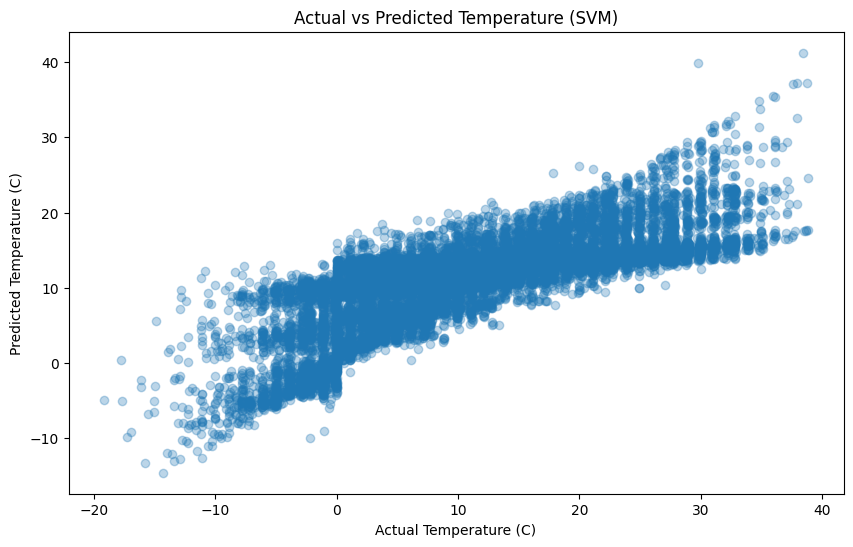

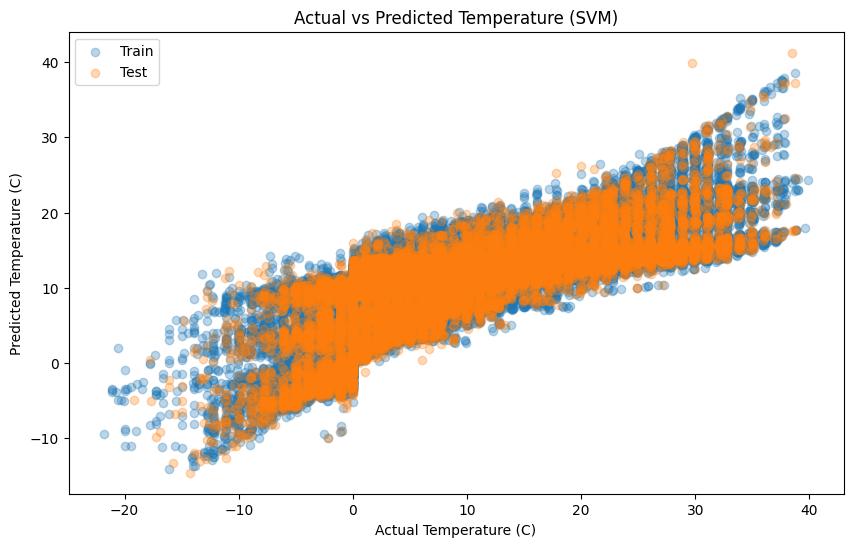

In [29]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the SVM model
svm_model = SVR(kernel='poly', degree=3)

# Train the SVM model
svm_model.fit(X_train_reshaped.squeeze(), y_train)

# Generate predictions
train_predictions = svm_model.predict(X_train_reshaped.squeeze())
test_predictions = svm_model.predict(X_test_reshaped.squeeze())

# Calculate evaluation metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_r2 = r2_score(y_train, train_predictions)
print("\nTrain Mean Absolute Error (MAE):", train_mae)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Train R2 Score:", train_r2)

test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_r2 = r2_score(y_test, test_predictions)
print("\nTest Mean Absolute Error (MAE):", test_mae)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print("Test R2 Score:", test_r2)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.3)
plt.xlabel('Actual Temperature (C)')
plt.ylabel('Predicted Temperature (C)')
plt.title('Actual vs Predicted Temperature (SVM)')
plt.show()


# plot the predicted vs actual values for train and test sets
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_predictions, alpha=0.3, label='Train')
plt.scatter(y_test, test_predictions, alpha=0.3, label='Test')
plt.xlabel('Actual Temperature (C)')
plt.ylabel('Predicted Temperature (C)')
plt.title('Actual vs Predicted Temperature (SVM)')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import learning_curve

# Define function for plotting learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curve
plot_learning_curve(svm_model, "Learning Curve (SVM)", X_train_reshaped.squeeze(), y_train, cv=5)
plt.show()
